# Convolutional Neural Network ResNet-50

In [1]:
import os
import numpy as np
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, f1_score
import matplotlib.pyplot as plt
import seaborn as sns


os.environ["CUDA_VISIBLE_DEVICES"]="1"

base_dir = 'uta_dataset/vgg16images'
drowsy_dir = os.path.join(base_dir, 'DrowsyVGG')
alert_dir = os.path.join(base_dir, 'AlertVGG')

# Creating a function to split data.
def create_splits(data_dir, output_dir, split_ratio=(0.7, 0.10, 0.20)):
    if not os.path.isdir(output_dir):
        os.mkdir(output_dir)
    
    for category in ['DrowsyVGG', 'AlertVGG']:
        category_dir = os.path.join(data_dir, category)
        images = os.listdir(category_dir)
        train_imgs, test_imgs = train_test_split(images, test_size=split_ratio[1] + split_ratio[2], random_state=42)
        val_imgs, test_imgs = train_test_split(test_imgs, test_size=split_ratio[2]/(split_ratio[1] + split_ratio[2]), random_state=42)
        
        for dset, imgs in zip(['train', 'val', 'test'], [train_imgs, val_imgs, test_imgs]):
            output_dset_dir = os.path.join(output_dir, dset, category)
            os.makedirs(output_dset_dir, exist_ok=True)
            for img in imgs:
                shutil.copy(os.path.join(category_dir, img), output_dset_dir)
                
# Splitting the dataset.
create_splits(base_dir, 'splitted_dataset')

# Preparing the data.
train_dir = os.path.join('splitted_dataset', 'train')
val_dir = os.path.join('splitted_dataset', 'val')
test_dir = os.path.join('splitted_dataset', 'test')

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=20,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=20,
    class_mode='binary')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=20,
    class_mode='binary',
    shuffle=False)


2024-02-28 14:50:04.416482: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


Found 7092 images belonging to 2 classes.
Found 1013 images belonging to 2 classes.
Found 2029 images belonging to 2 classes.


In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Conv2D, BatchNormalization, Activation, Add, Input, MaxPooling2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

class ResidualBlock(Layer):
    def __init__(self, filters, strides=1, **kwargs):
        super(ResidualBlock, self).__init__(**kwargs)
        self.filters = filters
        self.strides = strides
        self.conv1 = Conv2D(filters, 1, strides=strides, padding='same')
        self.bn1 = BatchNormalization()
        self.conv2 = Conv2D(filters, 3, padding='same')
        self.bn2 = BatchNormalization()
        self.conv3 = Conv2D(4*filters, 1, padding='same')
        self.bn3 = BatchNormalization()

        self.shortcut = Conv2D(4*filters, 1, strides=strides, padding='same')
        self.shortcut_bn = BatchNormalization()

    def call(self, inputs, training=False):
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = Activation('relu')(x)

        x = self.conv2(x)
        x = self.bn2(x, training=training)
        x = Activation('relu')(x)

        x = self.conv3(x)
        x = self.bn3(x, training=training)

        shortcut = self.shortcut(inputs)
        shortcut = self.shortcut_bn(shortcut, training=training)

        x = Add()([x, shortcut])
        x = Activation('relu')(x)
        return x
    
    def get_config(self):
        config = super(ResidualBlock, self).get_config()
        config.update({
            'filters': self.filters,
            'strides': self.strides
        })
        return config

def make_resnet50_binary_classification():
    inputs = Input(shape=(224, 224, 3))
    
    x = Conv2D(64, 7, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(3, strides=2, padding='same')(x)

    filters_list = [64, 128, 256, 512]
    blocks_list = [3, 4, 6, 3]  

    for filters, blocks in zip(filters_list, blocks_list):
        strides = 2 if filters > 64 else 1  
        x = ResidualBlock(filters, strides=strides)(x)
        for _ in range(1, blocks):
            x = ResidualBlock(filters, strides=1)(x)

    x = GlobalAveragePooling2D()(x)
    outputs = Dense(1, activation='sigmoid')(x)  

    model = Model(inputs=inputs, outputs=outputs)
    return model

resnet50_binary = make_resnet50_binary_classification()
resnet50_binary.summary()


2024-02-28 14:50:06.908123: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-02-28 14:50:06.909112: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-02-28 14:50:06.937637: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:5e:00.0 name: NVIDIA RTX A6000 computeCapability: 8.6
coreClock: 1.8GHz coreCount: 84 deviceMemorySize: 47.54GiB deviceMemoryBandwidth: 715.34GiB/s
2024-02-28 14:50:06.937690: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2024-02-28 14:50:06.940977: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2024-02-28 14:50:06.941063: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2024-0

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 112, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 56, 56, 64)        0         
_________________________________________________________________
residual_block (ResidualBloc (None, 56, 56, 256)       76928     
_________________________________________________________________
residual_block_1 (ResidualBl (None, 56, 56, 256)       138368

In [3]:
model=make_resnet50_binary_classification()

model.compile(optimizer=optimizers.Adamax(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks.
callbacks = [
    ModelCheckpoint('vgg16_drowsiness_detection.h5', save_best_only=True, monitor='val_accuracy',mode="max")
]

# Train the model.
history = model.fit(
    train_generator,
    steps_per_epoch=100,  
    epochs=50,
    validation_data=validation_generator,
    validation_steps=50,  
    callbacks=callbacks
)


2024-02-28 14:50:09.868013: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2024-02-28 14:50:09.868488: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2100000000 Hz


Epoch 1/50


2024-02-28 14:50:14.021012: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2024-02-28 14:50:14.756719: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2024-02-28 14:50:14.765827: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8
2024-02-28 14:50:17.878050: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


100/100 [==============================] - 20s 112ms/step - loss: 0.7550 - accuracy: 0.5641 - val_loss: 0.8665 - val_accuracy: 0.5000
Epoch 2/50
100/100 [==============================] - 11s 108ms/step - loss: 0.6489 - accuracy: 0.6207 - val_loss: 0.8126 - val_accuracy: 0.4950
Epoch 3/50
100/100 [==============================] - 10s 101ms/step - loss: 0.5684 - accuracy: 0.7032 - val_loss: 1.0275 - val_accuracy: 0.5350
Epoch 4/50
100/100 [==============================] - 10s 100ms/step - loss: 0.5458 - accuracy: 0.7041 - val_loss: 1.2299 - val_accuracy: 0.5320
Epoch 5/50
100/100 [==============================] - 10s 100ms/step - loss: 0.4710 - accuracy: 0.7770 - val_loss: 0.9041 - val_accuracy: 0.5560
Epoch 6/50
100/100 [==============================] - 10s 100ms/step - loss: 0.4267 - accuracy: 0.8049 - val_loss: 0.7272 - val_accuracy: 0.6570
Epoch 7/50
100/100 [==============================] - 10s 100ms/step - loss: 0.3440 - accuracy: 0.8520 - val_loss: 1.0046 - val_accuracy: 0.6

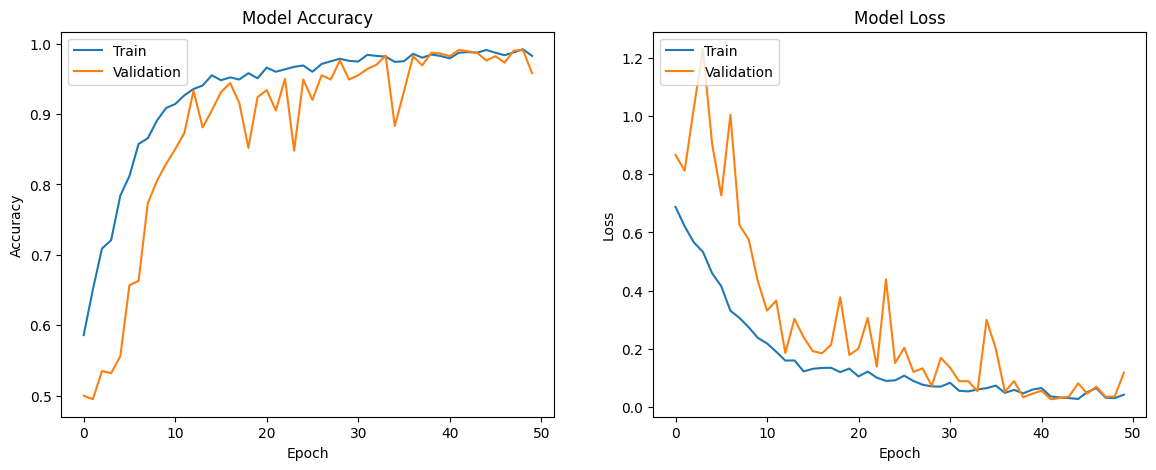

In [4]:
# Plot training & validation accuracy values.
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values.
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


50/50 [==============================] - 1s 29ms/step - loss: 0.0104 - accuracy: 0.9960
Test accuracy: 0.9959999918937683
F1 Score: 0.9520865533230294


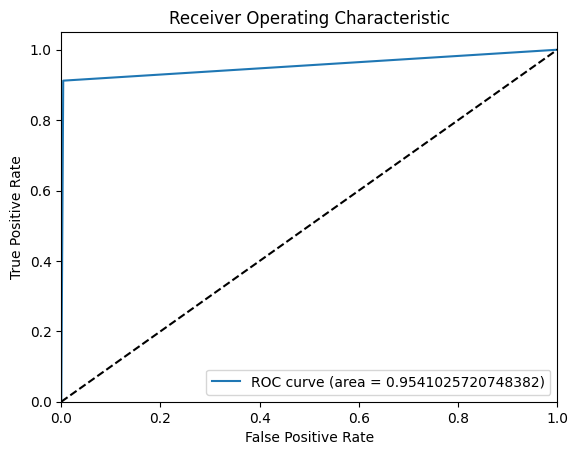

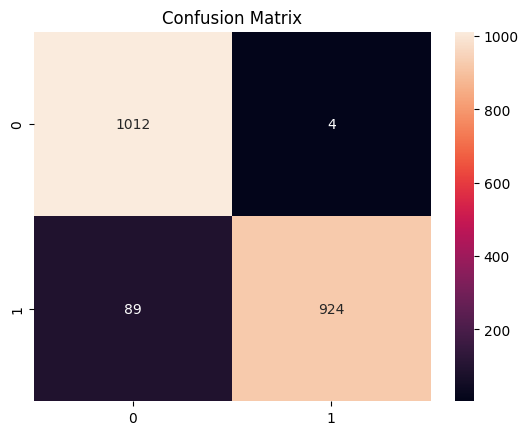

Sensitivity: 0.9960629921259843
Specificity: 0.912142152023692


In [5]:
# Evaluate the model on the test set.
test_loss, test_acc = model.evaluate(test_generator, steps=50)  
print(f"Test accuracy: {test_acc}")

# Predictions for ROC and F1.
y_pred = model.predict(test_generator)
y_pred = (y_pred > 0.5).astype(int)
y_true = test_generator.classes

f1 = f1_score(y_true, y_pred)
print(f"F1 Score: {f1}")

# ROC Curve.
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Confusion Matrix for Sensitivity and Specificity.
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.show()

# Sensitivity and Specificity.
sensitivity = cm[0,0] / (cm[0,0] + cm[0,1])
specificity = cm[1,1] / (cm[1,0] + cm[1,1])
print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")


In [6]:
# Carbon Tracker.
import gc
from carbontracker.tracker import CarbonTracker

tracker = CarbonTracker(epochs=50)
tracker.epoch_start()

history_tracker= model.fit(
    train_generator,
    steps_per_epoch=100,  
    epochs=1,
    validation_data=validation_generator,
    validation_steps=50,  
)
tracker.epoch_end()
tracker.stop()
gc.collect()

CarbonTracker: The following components were found: GPU with device(s) NVIDIA RTX A6000. CPU with device(s) cpu:1, cpu:0.
100/100 [==============================] - 10s 100ms/step - loss: 0.0426 - accuracy: 0.9869 - val_loss: 0.1773 - val_accuracy: 0.9380
CarbonTracker: 
Actual consumption for 1 epoch(s):
	Time:	0:00:10
	Energy:	0.001506 kWh
	CO2eq:	0.402168 g
	This is equivalent to:
	0.003340 km travelled by car
CarbonTracker: 
Predicted consumption for 50 epoch(s):
	Time:	0:08:24
	Energy:	0.075312 kWh
	CO2eq:	20.259037 g
	This is equivalent to:
	0.168264 km travelled by car
CarbonTracker: Finished monitoring.


7766